In [ ]:
import warnings                               
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping


### **2: Prediction model**

In this section, we create a prediction model using three different models, based on Stations Name, which is split into hourly intervals, summarizing energy usage and generating features like historical averages, time of day, and lag features. We evaluate the model using training, validation, and test datasets to assess performance.

In [52]:
# Function to split charging events into hourly intervals
def split_events_hourly(data):
    expanded_data = []
    for _, row in data.iterrows():
        start_time = row['Start Date UTC']
        end_time = row['End Date UTC']
        current_time = start_time.floor('H')

        while current_time < end_time:
            next_hour = min(current_time + pd.Timedelta(hours=1), end_time)
            overlap_seconds = (next_hour - current_time).total_seconds()
            overlap_fraction = overlap_seconds / 3600  # Fraction of the hour
            
            expanded_data.append({
                'Hour': current_time,
                'Station Name': row['Station Name'],
                'User ID': row['User ID'],
                'Energy (kWh)': overlap_fraction * row['Energy (kWh)'],  # Proportion of energy for this hour
                'Overlap (min)': overlap_seconds / 60  # Overlap in minutes
            })
            current_time += pd.Timedelta(hours=1)

    return pd.DataFrame(expanded_data)

In [53]:
# Convert Start Date and End Date to datetime
data['Start Date UTC'] = pd.to_datetime(data['Start Date UTC'])
data['End Date UTC'] = pd.to_datetime(data['End Date UTC'])

# Apply the splitting function
hourly_data = split_events_hourly(data)

# Check hourly data
print(hourly_data.head())

                       Hour  Station Name  User ID  Energy (kWh)  \
0 2011-07-30 03:00:00+00:00            12     3284      6.249457   
1 2011-07-30 04:00:00+00:00            12     3284      6.249457   
2 2011-07-30 05:00:00+00:00            12     3284      6.249457   
3 2011-07-30 06:00:00+00:00            12     3284      2.083152   
4 2011-07-30 07:00:00+00:00            12     4169      0.003553   

   Overlap (min)  
0           60.0  
1           60.0  
2           60.0  
3           20.0  
4            2.0  


In [54]:
# Aggregate energy usage per station and hour
combined_data = hourly_data.groupby(['Hour', 'Station Name'], as_index=False).agg({
    'Energy (kWh)': 'sum'
})

# Add Day of Week
combined_data['Day of Week'] = combined_data['Hour'].dt.dayofweek  # 0 = Monday, 6 = Sunday

# Add Time of Day
def time_of_day(hour):
    if 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    elif 18 <= hour < 24:
        return 'Evening'
    else:
        return 'Night'

combined_data['Time of Day'] = combined_data['Hour'].dt.hour.apply(time_of_day)

# Add Historical Average Energy Usage
combined_data['Historical Avg (kWh)'] = combined_data.groupby(
    ['Station Name', combined_data['Hour'].dt.hour]
)['Energy (kWh)'].transform('mean')

# Add Lag Features
combined_data['Energy Lag 1'] = combined_data.groupby('Station Name')['Energy (kWh)'].shift(1)
combined_data['Energy Lag 24'] = combined_data.groupby('Station Name')['Energy (kWh)'].shift(24)

# Add Rolling Statistics
combined_data['Rolling Mean 3h'] = combined_data.groupby('Station Name')['Energy (kWh)'].transform(
    lambda x: x.rolling(3).mean()
)

# Fill NaNs resulting from lag/rolling
combined_data.fillna(0, inplace=True)

# Check data with features
print(combined_data.head())

# Sort by time to prevent data leakage
combined_data = combined_data.sort_values('Hour')

                       Hour  Station Name  Energy (kWh)  Day of Week  \
0 2011-07-30 03:00:00+00:00            12      6.249457            5   
1 2011-07-30 04:00:00+00:00            12      6.249457            5   
2 2011-07-30 05:00:00+00:00            12      6.249457            5   
3 2011-07-30 06:00:00+00:00            12      2.083152            5   
4 2011-07-30 07:00:00+00:00            12      0.003553            5   

  Time of Day  Historical Avg (kWh)  Energy Lag 1  Energy Lag 24  \
0       Night              8.302988      0.000000            0.0   
1       Night              8.467789      6.249457            0.0   
2       Night              9.987614      6.249457            0.0   
3     Morning             12.847300      6.249457            0.0   
4     Morning             15.557943      2.083152            0.0   

   Rolling Mean 3h  
0         0.000000  
1         0.000000  
2         6.249457  
3         4.860689  
4         2.778721  


In [55]:
# Split into train (70%) and test (30%)
train_data, test_data = train_test_split(combined_data, test_size=0.3, random_state=42, shuffle=False)

# Split training data into train (80%) and validation (20%)
train_final, validation_train = train_test_split(train_data, test_size=0.2, random_state=42, shuffle=False)

# Split test data into test (50%) and validation-test (50%)
test_final, validation_test = train_test_split(test_data, test_size=0.5, random_state=42, shuffle=False)

# Print dataset sizes
print(f"Dataset Sizes:")
print(f"Train Final: {len(train_final)} ({len(train_final) / len(combined_data) * 100:.2f}%)")
print(f"Validation Train: {len(validation_train)} ({len(validation_train) / len(combined_data) * 100:.2f}%)")
print(f"Validation Test: {len(validation_test)} ({len(validation_test) / len(combined_data) * 100:.2f}%)")
print(f"Test Final: {len(test_final)} ({len(test_final) / len(combined_data) * 100:.2f}%)")

Dataset Sizes:
Train Final: 357016 (56.00%)
Validation Train: 89255 (14.00%)
Validation Test: 95630 (15.00%)
Test Final: 95629 (15.00%)


In [56]:
# Define features and target
X_features = ['Historical Avg (kWh)', 'Day of Week', 'Energy Lag 1', 'Energy Lag 24', 'Rolling Mean 3h']
y_target = 'Energy (kWh)'

X_train = train_final[X_features]
y_train = train_final[y_target]

X_validation = validation_train[X_features]
y_validation = validation_train[y_target]

X_test = test_final[X_features]
y_test = test_final[y_target]

We use Linear Regression as a baseline model, to predict energy usage, because it is simple and interpretable.

In [ ]:
# Function to evaluate classification metrics for regression model
def evaluate_regression(y_true, y_pred, threshold=0.5):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"MSE: {mse:.2f}, MAE: {mae:.2f}, R²: {r2:.2f}")

In [58]:
# Train Linear Regression Model
baseline_model = LinearRegression()
baseline_model.fit(X_train, y_train)

LinearRegression()

In [ ]:
# Predicion and evaluation
y_pred_validation = baseline_model.predict(X_validation)
evaluate_regression(y_validation, y_pred_validation, threshold=0.5)

y_pred_test = baseline_model.predict(X_test)
evaluate_regression(y_test, y_pred_test, threshold=0.5)

MSE: 23.91, MAE: 3.27, R²: 0.81
MSE: 29.97, MAE: 3.67, R²: 0.80


The MSE is 23.91 for the validation set and 29.97 for the test set, and the MAE is 3.27 and 3.67, respectively. These values indicate that the model has a reasonable prediction performance, with relatively low errors. The R² values of 0.81 and 0.80 suggest that the model explains about 81% and 80% of the variance in the data, showing a good fit.

We use a Random Forest model to predict energy consumption, as it performs well with complex, non-linear relationships.

In [60]:
# Train Random Forest Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [ ]:
# Predicion and evaluation
y_pred_rf = rf_model.predict(X_test)
evaluate_regression(y_test, y_pred_rf)

MSE: 27.67, MAE: 3.43, R²: 0.82


The MSE is 27.67, the MAE is 3.43, and the R² is 0.82, indicating good model performance. To improve it further, we use RandomizedSearchCV to optimize hyperparameters, exploring different combinations of estimators, depth, split criteria, and features through 3-fold cross-validation.

In [ ]:
# Hyperparameter Tuning with RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
}

# Setup the RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist,
    n_iter=10, # Number of parameter settings that are sampled
    cv=3, # Number of folds in cross-validation
    n_jobs=1, # Number of jobs to run in parallel
    verbose=2, # Controls the verbosity
    random_state=42 # Random seed
)

# Fit the RandomizedSearchCV
random_search.fit(X_train, y_train)

# Print best hyperparameters
print(f"Best hyperparameters: {random_search.best_params_}")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.0s
[CV] END max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time= 1.0min
[CV] END max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=

In [73]:
# Prediction and evaluation
y_pred_rf = random_search.best_estimator_.predict(X_test)
evaluate_regression(y_test, y_pred_rf)

MSE: 26.50, MAE: 3.41, R²: 0.83


By turning the hyperparameters, we see that the optimized model gives an MSE of 26.56, MAE of 3.41, and R² of 0.83. This indicates an improvement in model performance, with a slightly lower error and a better fit, explaining 83% of the variance in the data.

We use a Neural Network model to predict energy consumption, because they are highly effective at modeling complex, non-linear relationships between input features and the target variable.

In [ ]:
# Build and Train Neural Network Model
def build_and_train_nn(X_train, y_train, X_validation, y_validation, X_test, y_test, epochs=50, batch_size=32, regularization_strength=0.001, use_dropout=True):
    nn_model = Sequential()
    
    # Add layers with L2 regularization to prevent overfitting and optional Dropout
    nn_model.add(Dense(128, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=regularizers.l2(regularization_strength)))
    if use_dropout:
        nn_model.add(Dropout(rate=0.5))
    
    nn_model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(regularization_strength)))
    if use_dropout:
        nn_model.add(Dropout(rate=0.5))

    nn_model.add(Dense(1))  # Output layer

    # Compile the model with Adam optimizer and Mean Squared Error loss function
    nn_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    # Train the model for 50 epocs with a batch size of 32 and evaluate on training and validation loss and Mean Absolute Error (MAE).
    history = nn_model.fit(X_train, y_train, validation_data=(X_validation, y_validation), epochs=epochs, batch_size=batch_size, verbose=2)

    return nn_model, history

# Call the function to train and evaluate the Neural Network model
nn_model, history = build_and_train_nn(X_train, y_train, X_validation, y_validation, X_test, y_test, epochs=50, batch_size=32, regularization_strength=0.001)

Epoch 1/50
11157/11157 - 5s - 467us/step - loss: 29.2872 - mae: 3.6876 - val_loss: 22.5471 - val_mae: 3.3075
Epoch 2/50
11157/11157 - 5s - 412us/step - loss: 24.7063 - mae: 3.3464 - val_loss: 22.3458 - val_mae: 3.1875
Epoch 3/50
11157/11157 - 5s - 415us/step - loss: 23.4188 - mae: 3.2542 - val_loss: 24.3141 - val_mae: 3.5091
Epoch 4/50
11157/11157 - 4s - 400us/step - loss: 22.9600 - mae: 3.2281 - val_loss: 22.5979 - val_mae: 3.2191
Epoch 5/50
11157/11157 - 5s - 421us/step - loss: 22.7086 - mae: 3.2183 - val_loss: 22.5136 - val_mae: 3.1861
Epoch 6/50
11157/11157 - 5s - 404us/step - loss: 22.5498 - mae: 3.2064 - val_loss: 24.1187 - val_mae: 3.5294
Epoch 7/50
11157/11157 - 4s - 387us/step - loss: 22.4838 - mae: 3.2112 - val_loss: 22.4864 - val_mae: 3.2794
Epoch 8/50
11157/11157 - 4s - 398us/step - loss: 22.3286 - mae: 3.2033 - val_loss: 23.7677 - val_mae: 3.4774
Epoch 9/50
11157/11157 - 5s - 411us/step - loss: 22.2983 - mae: 3.1997 - val_loss: 22.2664 - val_mae: 3.1980
Epoch 10/50
11157/1

In [77]:
# Predicion and evaluation
y_pred_nn = nn_model.predict(X_test)
evaluate_regression(y_test, y_pred_nn)

2989/2989 ━━━━━━━━━━━━━━━━━━━━ 1s 296us/step
MSE: 27.73, MAE: 3.71, R²: 0.82


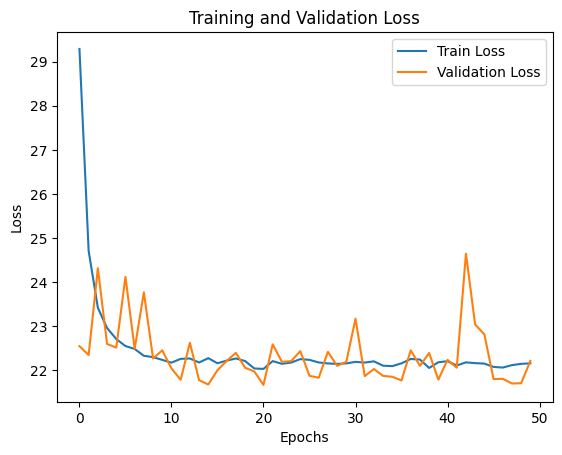

In [78]:
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

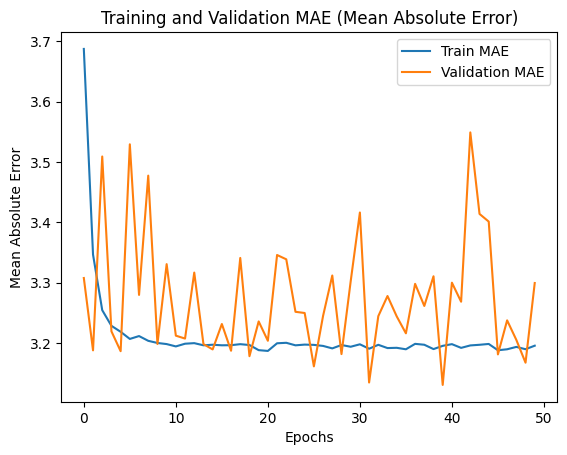

In [79]:
plt.plot(history.history["mae"], label="Train MAE")
plt.plot(history.history["val_mae"], label="Validation MAE")
plt.title("Training and Validation MAE (Mean Absolute Error)")
plt.xlabel("Epochs")
plt.ylabel("Mean Absolute Error")
plt.legend()
plt.show()

We see that the MSE is 27.73, the MAE is 3.71, and the R² is 0.82, indicating the model performs well with a moderate error and a good fit, explaining 82% of the variance. The plots show that the training loss and MAE decrease quickly, but the validation loss and MAE fluctuate, suggesting potential overfitting. Therefore, we use early stopping to prevent overfitting and to save computational resources by halting training when no improvement is seen in the validation loss.

In [ ]:
# Set lower learning rate
optimizer = Adam(learning_rate=0.0001)

# Build Neural Network Model
nn_model = Sequential()
nn_model.add(Dense(64, input_dim=len(X_features), activation='relu'))
nn_model.add(Dropout(0.5)) 
nn_model.add(BatchNormalization())  # Add batch normalization to stabilize
nn_model.add(Dense(32, activation='relu'))
nn_model.add(Dropout(0.5)) 
nn_model.add(Dense(1)) 

# Compile the model
nn_model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# Implement early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = nn_model.fit(X_train, y_train, validation_data=(X_validation, y_validation),
                       epochs=50, batch_size=32, verbose=2, callbacks=[early_stopping])

Epoch 1/50
11157/11157 - 5s - 480us/step - loss: 83.5012 - mae: 6.1304 - val_loss: 26.3217 - val_mae: 3.6675
Epoch 2/50
11157/11157 - 5s - 439us/step - loss: 49.3626 - mae: 4.7699 - val_loss: 27.8341 - val_mae: 3.6893
Epoch 3/50
11157/11157 - 5s - 430us/step - loss: 46.5737 - mae: 4.6147 - val_loss: 28.3926 - val_mae: 3.7600
Epoch 4/50
11157/11157 - 5s - 409us/step - loss: 44.4302 - mae: 4.5172 - val_loss: 28.8983 - val_mae: 3.7023
Epoch 5/50
11157/11157 - 4s - 399us/step - loss: 42.8152 - mae: 4.4434 - val_loss: 31.0900 - val_mae: 3.8024
Epoch 6/50
11157/11157 - 4s - 402us/step - loss: 41.4690 - mae: 4.3883 - val_loss: 29.8661 - val_mae: 3.7243
Epoch 7/50
11157/11157 - 5s - 405us/step - loss: 40.7476 - mae: 4.3550 - val_loss: 30.3835 - val_mae: 3.8085
Epoch 8/50
11157/11157 - 4s - 396us/step - loss: 40.1277 - mae: 4.3184 - val_loss: 31.3943 - val_mae: 3.8211
Epoch 9/50
11157/11157 - 5s - 417us/step - loss: 39.4738 - mae: 4.2794 - val_loss: 31.0974 - val_mae: 3.8078
Epoch 10/50
11157/1

In [82]:
# Predicion and evaluation
y_pred_nn = nn_model.predict(X_test)
evaluate_regression(y_test, y_pred_nn, threshold=0.5)

2989/2989 ━━━━━━━━━━━━━━━━━━━━ 1s 241us/step
MSE: 33.10, MAE: 4.09, R²: 0.78


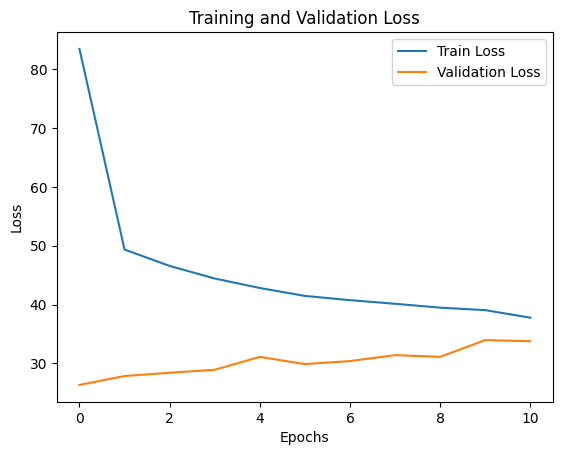

In [83]:
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

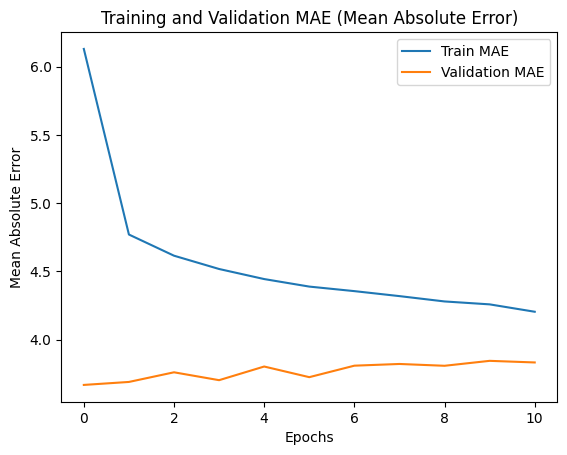

In [84]:
plt.plot(history.history["mae"], label="Train MAE")
plt.plot(history.history["val_mae"], label="Validation MAE")
plt.title("Training and Validation MAE (Mean Absolute Error)")
plt.xlabel("Epochs")
plt.ylabel("Mean Absolute Error")
plt.legend()
plt.show()

We see that the MSE is 33.10, the MAE is 4.09, and the R² is 0.78, which shows that the model performs with moderate error but less accuracy compared to previous results. The plots indicate that the training loss steadily decreases, while the validation loss stabilizes, suggesting that early stopping helped prevent overfitting and achieved better generalization.

To compare the three models, we use MSE, MAE, and R² metrics.

In [91]:
# Function to evaluate and compare models
def compare_models(models, X_test, y_test, model_names):
    results = []
    for model, name in zip(models, model_names):
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        results.append((name, mse, mae, r2))
        
    results_df = pd.DataFrame(results, columns=['Model', 'MSE', 'MAE', 'R²'])
    return results_df

# Example usage
models = [rf_model, nn_model, baseline_model]  # List of models
model_names = ['Random Forest', 'Neural Network', 'Linear Regression']  # Model names
comparison_results = compare_models(models, X_test, y_test, model_names)

# Display the comparison results
print(comparison_results)

2989/2989 ━━━━━━━━━━━━━━━━━━━━ 1s 234us/step
               Model        MSE       MAE        R²
0      Random Forest  27.668530  3.425832  0.818666
1     Neural Network  33.104568  4.085303  0.783039
2  Linear Regression  29.966981  3.674082  0.803602


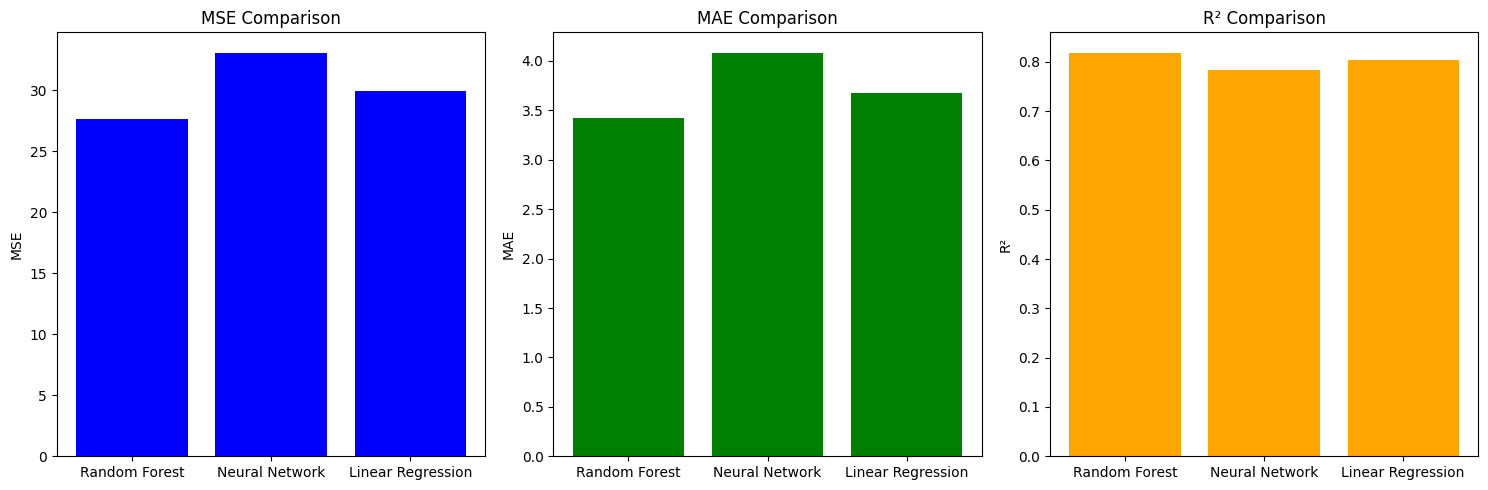

In [ ]:
# Plot MSE, MAE, and R² for model comparison
def plot_comparison(results_df):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # MSE Plot
    axes[0].bar(results_df['Model'], results_df['MSE'], color='blue')
    axes[0].set_title('MSE Comparison')
    axes[0].set_ylabel('MSE')

    # MAE Plot
    axes[1].bar(results_df['Model'], results_df['MAE'], color='green')
    axes[1].set_title('MAE Comparison')
    axes[1].set_ylabel('MAE')

    # R² Plot
    axes[2].bar(results_df['Model'], results_df['R²'], color='orange')
    axes[2].set_title('R² Comparison')
    axes[2].set_ylabel('R²')

    plt.tight_layout()
    plt.show()

# Plot the comparison
plot_comparison(comparison_results)

The MSE and MAE show that the Random Forest model has the lowest error, while the R² indicates that it explains more variance in the data compared to the Neural Network and Linear Regression models.

2989/2989 ━━━━━━━━━━━━━━━━━━━━ 1s 245us/step


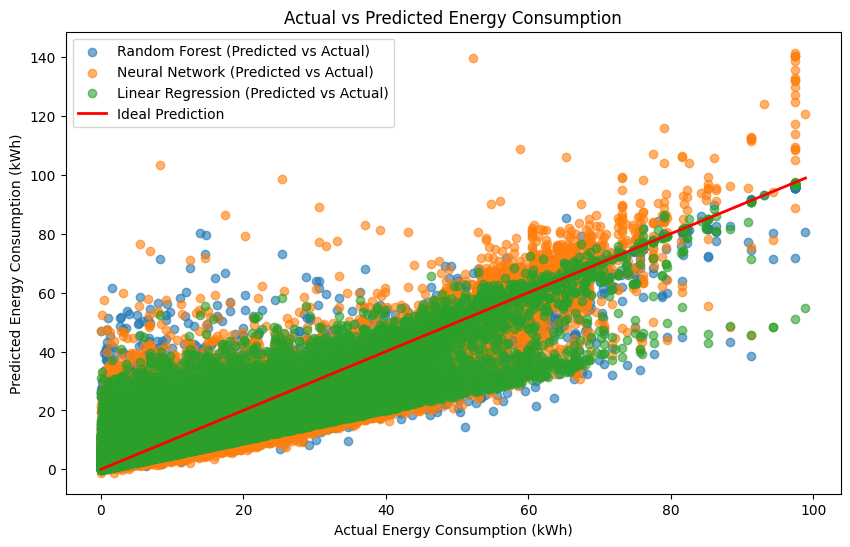

In [93]:
# Compare actual vs predicted for each model
def plot_actual_vs_predicted(y_test, models, model_names):
    plt.figure(figsize=(10, 6))
    for model, name in zip(models, model_names):
        y_pred = model.predict(X_test)
        plt.scatter(y_test, y_pred, label=f'{name} (Predicted vs Actual)', alpha=0.6)
    
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2, label='Ideal Prediction')
    plt.title('Actual vs Predicted Energy Consumption')
    plt.xlabel('Actual Energy Consumption (kWh)')
    plt.ylabel('Predicted Energy Consumption (kWh)')
    plt.legend()
    plt.show()

# Example usage
plot_actual_vs_predicted(y_test, models, model_names)

These plots also show that the Random Forest and Neural Network models are better suited for predicting energy consumption, which matches the comparison for MSE, MAE, and R², because they have predictions closer to the ideal line, indicating better accuracy and fit compared to Linear Regression

# **Word Count**
---

In [86]:
import json

with open('Predicion_model.ipynb') as json_file:
    data = json.load(json_file)

print(data)

{'cells': [{'cell_type': 'code', 'execution_count': 1, 'metadata': {}, 'outputs': [], 'source': ['import warnings                               \n', "warnings.filterwarnings('ignore')\n", '\n', 'import pandas as pd\n', 'import matplotlib.pyplot as plt\n', '\n', 'from sklearn.model_selection import train_test_split\n', 'from sklearn.linear_model import LinearRegression\n', 'from sklearn.metrics import mean_squared_error, mean_absolute_error\n', 'from sklearn.ensemble import RandomForestRegressor\n', '\n', 'from tensorflow.keras.models import Sequential\n', 'from tensorflow.keras.layers import Dense']}, {'cell_type': 'markdown', 'metadata': {}, 'source': ['## **Initializing**']}, {'cell_type': 'code', 'execution_count': 2, 'metadata': {}, 'outputs': [], 'source': ['import warnings                               \n', "warnings.filterwarnings('ignore')\n", 'import pandas as pd\n', 'import numpy as np\n', 'import matplotlib.pyplot as plt\n', 'import seaborn as sns\n', 'from sklearn.preproces

In [87]:
wordCount = 0
for each in data['cells']:
    cellType = each['cell_type']
    if cellType == "markdown":
        content = each['source']
        for line in content:
            temp = [word for word in line.split() if "#" not in word] # we might need to filter for more markdown keywords here
            wordCount = wordCount + len(temp)
            
print(wordCount)

2896
